c:\Users\LIM TZE TA\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\LIM TZE TA\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\LIM TZE TA\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorfl


--- XGBoost Regression Results (Log-Transformed Target + Selected Features) ---
MAE  = 117,004.22
RMSE = 253,957.24
R²   = 0.633


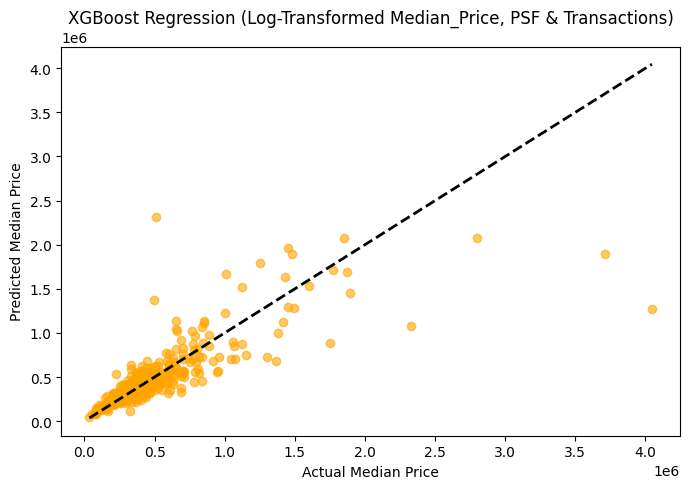

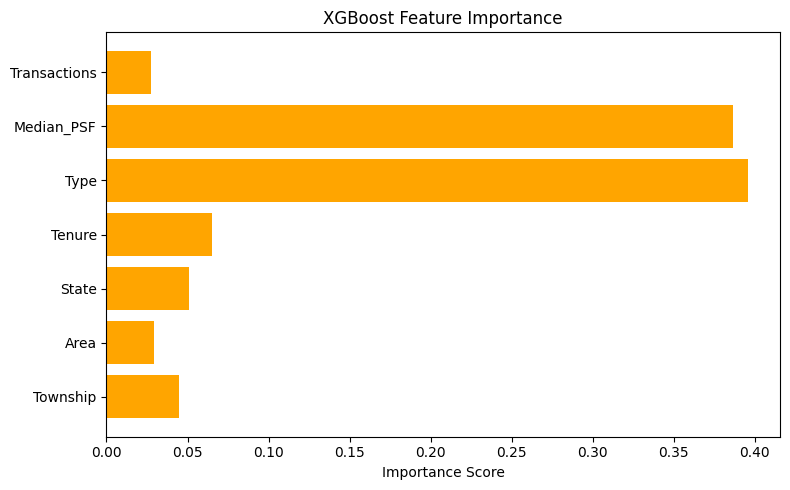

In [10]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# --- Step 1: Load Dataset (Already Label-Encoded) ---
df = pd.read_csv("malaysia_house_price_data_2025_label_encoded.csv")

# --- Step 2: Log-transform selected columns ---
log_cols = ["Median_Price", "Median_PSF", "Transactions"]
for col in log_cols:
    df[col] = np.log1p(df[col])  # log(1 + x) handles zeros safely

# --- Step 3: Separate Features and Target ---
X = df.drop(columns="Median_Price")
y = df["Median_Price"].values.reshape(-1, 1)

# --- Step 4: Split Dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Step 5: Standardize features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 6: Initialize and Train XGBoost Model ---
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.2,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    reg_alpha=0.1,   # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    n_jobs=-1
)

xgb.fit(X_train_scaled, y_train.ravel())

# --- Step 7: Make Predictions ---
y_pred_log = xgb.predict(X_test_scaled)

# --- Step 8: Inverse log transform for target variable ---
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

# --- Step 9: Evaluate Model Performance ---
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print("\n--- XGBoost Regression Results (Log-Transformed Target + Selected Features) ---")
print(f"MAE  = {mae:,.2f}")
print(f"RMSE = {rmse:,.2f}")
print(f"R²   = {r2:.3f}")

# --- Step 10: Visualization: Actual vs Predicted ---
plt.figure(figsize=(7, 5))
plt.scatter(y_actual, y_pred, color='orange', alpha=0.6)
plt.plot([y_actual.min(), y_actual.max()],
         [y_actual.min(), y_actual.max()],
         'k--', lw=2)
plt.xlabel("Actual Median Price")
plt.ylabel("Predicted Median Price")
plt.title("XGBoost Regression (Log-Transformed Median_Price, PSF & Transactions)")
plt.tight_layout()
plt.show()

# --- Step 11: Feature Importance ---
plt.figure(figsize=(8, 5))
importances = xgb.feature_importances_
plt.barh(X.columns, importances, color='orange')
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

--- Deep Learning Results ---
MAE  = 198,954.46
RMSE = 362,695.68
R²   = 0.252

=== Model Performance Comparison ===
                Model           MAE          RMSE       R²
              XGBoost 117004.222266 253957.235412 0.633387
Deep Learning (Keras) 198954.462080 362695.681972 0.252224


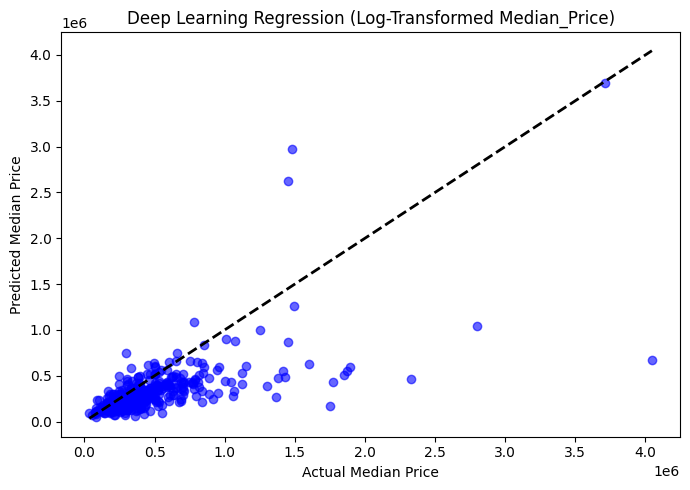

In [13]:
# --- Step 7: Deep Learning Model (TensorFlow/Keras) ---
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(32, activation='relu'),
    
    layers.Dense(1)  # regression output (log-transformed)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Train model
history = model.fit(
    X_train_scaled, y_train,  # y_train is already log-transformed
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0
)

# Predict
y_pred_log_dl = model.predict(X_test_scaled)
y_pred_dl = np.expm1(y_pred_log_dl).flatten()  # inverse log-transform

# Evaluate
mae_dl = mean_absolute_error(y_actual, y_pred_dl)
rmse_dl = np.sqrt(mean_squared_error(y_actual, y_pred_dl))
r2_dl = r2_score(y_actual, y_pred_dl)

print("\n--- Deep Learning Results ---")
print(f"MAE  = {mae_dl:,.2f}")
print(f"RMSE = {rmse_dl:,.2f}")
print(f"R²   = {r2_dl:.3f}")

# --- Step 8: Compare in Table ---
results = pd.DataFrame({
    "Model": ["XGBoost", "Deep Learning (Keras)"],
    "MAE": [mae, mae_dl],
    "RMSE": [rmse, rmse_dl],
    "R²": [r2, r2_dl]
})

print("\n=== Model Performance Comparison ===")
print(results.to_string(index=False))

# --- Step 9: Plot Actual vs Predicted (DL) ---
plt.figure(figsize=(7, 5))
plt.scatter(y_actual, y_pred_dl, color='blue', alpha=0.6)
plt.plot([y_actual.min(), y_actual.max()],
         [y_actual.min(), y_actual.max()],
         'k--', lw=2)
plt.xlabel("Actual Median Price")
plt.ylabel("Predicted Median Price")
plt.title("Deep Learning Regression (Log-Transformed Median_Price)")
plt.tight_layout()
plt.show()
